# ITP40010-2 Machine Learning Final Exam (Code)

This file contains the coding portion of the final exam, ITP40010-2 Machine Learning, 2021.
Read the instruction carefully.

## Preparatory scripts and data

This part of the document contains the preparatory scripts that load and preprocess data.
Read and execute the code snippets below before you work on any of the problems.

In [ ]:
# Imports
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [ ]:
# Utility functions
def normalize(X, mu=None, sigma=None):
    """
    Normalizes input matrix X.
    If mu and sigma are provided, this function normalizes X using them.
    Otherwise, the function first estimates mu and sigma from X, and then normalizes X.
    Input: X - input matrix
           mu - a vector of column-wise mean values (can be omitted)
           sigma - a vector of column-wise standard deviation values (can be omitted)
    Output: 
    """
    if mu is None and sigma is None:
        mu = X.mean(axis=0)
        sigma = X.std(axis=0)
    return (X - mu)/sigma, mu, sigma


def get_accuracy(Y_true, Y_pred):
    """
    Measures the classification accuracy.
    Input: Y_true - true label vector (ground truth)
           Y_pred - predicted label vector
    return a floating point number representing accuracy
    """
    assert len(Y_true) == len(Y_pred)  # optional - assert makes sure a certain condition satisfies
    return np.sum(Y_true == Y_pred)/len(Y_true)
    

In [ ]:
# Data prep.

# Step 1) Load raw data
data = np.genfromtxt('breast-cancer-wisconsin.csv', delimiter=',', skip_header=0)
# print(data)

# Step 2) Remove rows with missing values
data=data[~np.isnan(data).any(axis=1)]

# Step 3) Split data into X and y
X = data[:, 1:-1]
y = data[:, -1]

# Step 4) Create a 0/1 label vector 
y[y==2] = 0  # benign
y[y==4] = 1  # malignant

# Step 5) Split data into 90% (615 instances) of trainset (X_tr, y_tr) and
#        10% (68 instances) of testset (X_ts, y_ts)
N = data.shape[0]
N_tr = np.round(N*.9).astype(int)

X_tr = X[:N_tr, :]
y_tr = y[:N_tr]

X_ts = X[N_tr:, :]
y_ts = y[N_tr:]

print(X_tr.shape)
print(y_tr.shape)
print(X_ts.shape)
print(y_ts.shape)
# print(X_tr)
# print(X_ts)

# Step 6) Normalize the input attributes using your normalize() function
X_tr, mu_tr, sigma_tr = normalize(X_tr)
#mu = u
X_ts, _, _ = normalize(X_ts, mu_tr, sigma_tr)
# print(X_tr)
# print(X_ts)

N = X_tr.shape[0]
m = X_tr.shape[1]

#N = 615 , m = 9 (number of features)


(615, 9)
(615,)
(68, 9)
(68,)


In [ ]:
# Prepare data frames

import pandas as pd

X_tr_df = pd.DataFrame(X_tr, columns=['clump', 'u_cell_sz', 'u_cell_shp',
                                     'adhesion','se_cell_sz','nuclei',
                                     'chromatin','nucleioli','mitoses'])
y_tr_df = pd.Categorical(y_tr, categories=[0, 1])
# print(X_tr_df)
# print(y_tr_df)

X_tr_df.shape

#training data is normalized by here 
#normalized X = X_tr

(615, 9)

## A. Linear Discriminant Analysis (LDA)

**(a) Below provides a code skeleton for linear discriminant analysis. Complete the code such that it computes `S_w` and `S_b` as discussed in class.**

In [ ]:
# Train LDA
# Getting per-class mean vectors
X_tr_stats = X_tr_df.join(pd.Series(y_tr_df, name='class'))
#X_tr_stats = X_tr_df + y_tr_df
class_feature_means = pd.DataFrame(columns=[0,1])

for c, rows in X_tr_stats.groupby('class'):
  class_feature_means[c] = rows.mean(numeric_only=True)

#class_feature_means[0] = class 0 average per feature
#class_feture_measn[1] = class 1 average per feature
    
# Computing the "within class" scatter
S_w = np.zeros((m, m))

## TODO: compute the "within class" scatter, S_w

class_labels = np.unique(y_tr_df)

for c in class_labels:
  X_c = X_tr_df[y_tr_df == c]
  S_w += (X_c - class_feature_means[c]).T.dot(X_c - class_feature_means[c])

# Computing the "between classes" scatter
feature_means = X_tr_stats.mean(numeric_only=True)
S_b = np.zeros((m, m))

## TODO: compute the "between classes" scatter, S_b 

for c in class_labels:
  mean_diff = (class_feature_means[c] - feature_means).values.reshape(m,1)
  #print(mean_diff)
  X_c = X_tr_df[y_tr_df == c]
  num_c = X_c.shape[0]
  S_b += num_c * (mean_diff) * (mean_diff).T

print(pd.DataFrame(S_w))
print(pd.DataFrame(S_b))


# EVD
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

#for pair in pairs:
#  print(pair[0])


                 clump   u_cell_sz  ...   nucleioli     mitoses
clump       298.315707   41.244621  ...   10.762675   30.502465
u_cell_sz    41.244621  212.374316  ...   80.850090   73.472742
u_cell_shp   46.234538  149.443251  ...   81.910439   57.632513
adhesion    -12.488340   79.462845  ...   62.777873   69.688808
se_cell_sz   15.833233  121.747891  ...   77.323333  114.377733
nuclei       -1.835958   17.315613  ...    5.872512   -4.620759
chromatin     7.851536   83.412027  ...   73.937838   10.063752
nucleioli    10.762675   80.850090  ...  307.898735   79.337924
mitoses      30.502465   73.472742  ...   79.337924  504.366545

[9 rows x 9 columns]
            0           1           2  ...           6           7           8
0  316.684293  357.078745  360.009160  ...  328.283649  311.855972  187.178732
1  357.078745  402.625684  405.929886  ...  370.157648  351.634550  211.054189
2  360.009160  405.929886  409.261204  ...  373.195397  354.520287  212.786233
3  307.192601  346.376

For your reference, the `S_w` and `S_b` matrices that I computed are provided below:

In [ ]:
print(pd.DataFrame(S_w))
print(pd.DataFrame(S_b))


                 clump   u_cell_sz  ...   nucleioli     mitoses
clump       298.315707   41.244621  ...   10.762675   30.502465
u_cell_sz    41.244621  212.374316  ...   80.850090   73.472742
u_cell_shp   46.234538  149.443251  ...   81.910439   57.632513
adhesion    -12.488340   79.462845  ...   62.777873   69.688808
se_cell_sz   15.833233  121.747891  ...   77.323333  114.377733
nuclei       -1.835958   17.315613  ...    5.872512   -4.620759
chromatin     7.851536   83.412027  ...   73.937838   10.063752
nucleioli    10.762675   80.850090  ...  307.898735   79.337924
mitoses      30.502465   73.472742  ...   79.337924  504.366545

[9 rows x 9 columns]
            0           1           2  ...           6           7           8
0  316.684293  357.078745  360.009160  ...  328.283649  311.855972  187.178732
1  357.078745  402.625684  405.929886  ...  370.157648  351.634550  211.054189
2  360.009160  405.929886  409.261204  ...  373.195397  354.520287  212.786233
3  307.192601  346.376

After you complete and run your code for `S_w` and `S_b`, the following experiment should run with no problem.
It extracts a projection vector `w` from the analysis, and align the input instances on a single line (in the projected space).

In the resulting figure, x-axis represent the projection. Note that y-axis means nothing, as we simply assigned a random value to display what is happening on the projection space more clearly.

The colors of the data points represent the class labels. 
You will find most instances of the same kind fall in a similar region.
However, there is an area of confusion in the middle where instances from both classes are observed.

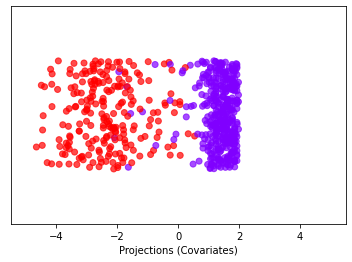

In [ ]:
w = np.hstack((pairs[0][1].reshape(m,1))).real

y_tr_out = np.array(X_tr.dot(w))
y_ts_out = np.array(X_ts.dot(w))

# print(y_tr_out)
# print(y_ts_out)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_code = le.fit_transform(X_tr_stats['class'])
plt.xlabel('Projections (Covariates)')
# plt.ylabel('')

plt.scatter(
    y_tr_out,
    np.random.rand(1,len(y_tr_out))/2 + .25,
    c=y_code,
    cmap='rainbow',
    alpha=0.7
)
plt.axis([-5.5, 5.5, 0, 1])
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

In order to use the model (that is, the `w` vector) for prediction, one needs to determine the decision threshold. Namely, we would like to fix a value that determines all projected value above it fall in class 1; otherwise, class 0.


**(b) Write a script that finds the best threshold value from the training data. And then perform a prediction on the testing data and report the accuracy.**

In [ ]:
## TODO: Complete the snippet
max_v = 0
thresh =0.0

mini = min(y_tr_out)
maxi = max(y_tr_out)

iter = np.linspace(mini/2, maxi/2, num=1000)

for thr in iter:
  y_tr_pred = []
  for i in range(0,len(y_tr_out)):
    if y_tr_out[i] > thr:
      y_tr_pred.append(0)
    else:
      y_tr_pred.append(1)
  acc = get_accuracy(y_tr, y_tr_pred)
  if max_v < acc:
    max_v = acc
    thresh = thr

print("The max training accuracy is " , acc)
print("The best threshold value is " , thresh)

y_ts_pred = []

for i in range(0, len(y_ts_out)):
  if y_ts_out[i] > thresh:
    y_ts_pred.append(0)
  else:
    y_ts_pred.append(1)

ts_acc = get_accuracy(y_ts, y_ts_pred)

print("The test data accuracy is " , ts_acc)



The max training accuracy is  0.9121951219512195
The best threshold value is  0.07114237290302672
The test data accuracy is  0.9852941176470589


## B. Logistic Regression

**(a) Implement the sigmoid function.**

In [ ]:
def sigmoid(z):
    # TODO: Complete the function such that 
    #       it returns the correct output of the sigmoid function
    return 1 / (1 + np.exp(-z))

Upon completion, you should see a nice sigmoid curve after running the following code.

(-8.0, 8.0)

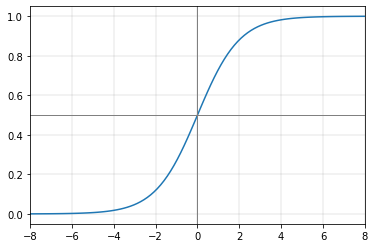

In [ ]:
!pip install --upgrade matplotlib

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

# visualizing the sigmoid function
z = np.linspace(-8,8,101)
v = sigmoid(z)  ## Your function is invoked

plt.plot(z, v)
plt.axvline(c='grey', lw=1)
plt.axline((-8, 0.5), (8, 0.5), c='grey', lw=1)

plt.grid(color='grey', linestyle='-', linewidth=.2)

plt.ylim(-0.05, 1.05)
plt.xlim(-8, 8)

**(b) Complete the `gradient_descent()` function such that it properly update w on each iteration.**

In [ ]:
def compute_cost(X, y, w):
    N = len(y)
    h = sigmoid(X @ w)
    epsilon = 1e-5
    cost = (1/N)*(((-y).T @ np.log(h + epsilon))-((1-y).T @ np.log(1-h + epsilon)))
    return cost



def gradient_descent(X, y, w, alpha, n_iters, threshold=1e-07):
    N = len(y)
    log_j = []
    j_last = np.Inf

    for i in range(n_iters):
        ## TODO: Complete the next line such that w_new have the updated weight values
        xdot = X.dot(w)
        y_hat = sigmoid(xdot)
        xdot2 = X.T.dot(y_hat - y)
        w_new = w - alpha * xdot2 / N
        j_new = compute_cost(X, y, w)
        
        if j_last - j_new < threshold:
            break
        
        w = w_new
        log_j.append(j_new)
        j_last = j_new

    return w, log_j

Your compelete `gradient_descent()` should run with the following `train_logreg()` function.

In [ ]:
# Problem 3 supplements: Additional function(s) required for this assignment
def train_logreg(X_tr, y_tr, alpha=0.01, n_iters=1500):
    """
    train_logreg
    Input: X_tr - Training input attributes
           y_tr - Training target labels
           alpha - learning rate alpha (default: 0.01)
           n_iters - number of iterations (default: 1500)
    Output: w_star - trained model weights
            log_j - cost history
    """
    N_tr, d_tr = X_tr.shape
    
    X_tr_b = np.hstack((X_tr, np.ones((N_tr, 1))))
    w_init = np.zeros(d_tr + 1)  # np.random.rand(d_tr + 1)
    
    initial_cost = compute_cost(X_tr_b, y_tr, w_init)
    print("Initial J(w_init, D_tr) is: ", initial_cost, "\n")
    
    w_star, log_j = gradient_descent(X_tr_b, y_tr, w_init, alpha, n_iters)
    
    print("w*: \n", w_star, "\n")
    print("J(w*, D_tr): ", log_j[-1])
    
    return w_star, log_j

**(c) Implement `predict_logreg(X, w)` that takes an input matrix (X) and a weight vector (w). The function returns the 0/1 predictions and estimated probability P(y=1|x) for the input instances.**

In [ ]:
def predict_logreg(X, w):
    """
    predict_logreg
    Input: X - Input attributes to predict the target output
           w - Trained model weights
    Output: y_pred - predicted target labels {0, 1}
            y_prob - estimated conditional probability P(y=1|x)
    """
    
    ## TODO: Complete this function
    N_x, d_x = X.shape
    
    X_ = np.hstack((X, np.ones((N_x, 1))))

    y_prob = X_.dot(w)
    y_pred = []
    for i in sigmoid(y_prob):
      if i > 0.5:
        y_pred.append(1)
      else:
        y_pred.append(0)
    
    return y_pred, y_prob

All in all, your complete code should run in the next experiment. A correct implementation would result in the accuracy evaluated on the breast cancer dataset much higher than 0.9.

In [ ]:
# Step 7) Train a logReg model
Model_logreg, log_j_logreg = train_logreg(X_tr, y_tr, 0.005, 3000)


# Step 8) Apply the trained LogReg model for prediction on both X_tr and X_ts
y_tr_pred, _ = predict_logreg(X_tr, Model_logreg)
y_ts_pred, _ = predict_logreg(X_ts, Model_logreg)

# Step 9) Measure the accuracy on y_tr and y_ts, respectively,
#        using your get_accuracy function.
print(get_accuracy(y_tr, y_tr_pred))
print(get_accuracy(y_ts, y_ts_pred))

Initial J(w_init, D_tr) is:  0.6931271807599426 

w*: 
 [ 0.69791806  0.60148189  0.65545492  0.5296396   0.46322818  0.82592807
  0.60273484  0.5292748   0.36595843 -0.45764689] 

J(w*, D_tr):  0.0962007329581487
0.9707317073170731
0.9852941176470589


**(d) Read the results. What are your accuracy on the training data and that of the testing data?**

Training accuracy is 0.9707317073170731

Test accuracy is 0.9852941176470589

**(e) Variable `log_j_logreg` contains the loss evaluated on each training iteration. Visualizing this variable highlights the progression of training. Plot the changes recorded in `log_j_logreg`; that is, x-axis is the iteration number, and y-axis is the output of the J function.**

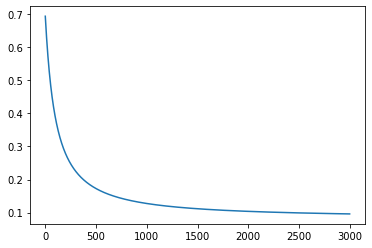

In [ ]:
## TODO: Plot the chnages recorded in log_j_logreg (a.k.a. learning curve)
plt.plot(log_j_logreg)
plt.show()

## C. Support Vector Machines (SVMs)

Let us get started with installing a required library. `cvxopt` is an optimization library that contains a large collection of solvers.

In [ ]:
!pip install cvxopt

In [ ]:
# Imports
import numpy as np
import cvxopt

Below is a complete code that defines, trains, and tests an SVM model.

In [ ]:
# https://github.com/corymaklin/svm/blob/master/svm.ipynb

class SVM:

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # P = X^T X 
        K = np.zeros((n_samples, n_samples)) #n_samples * n_samples matrix filled with zero
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j]) 
        P = cvxopt.matrix(np.outer(y, y) * K)
        # this sequence is used for optimization in dual problem.(alpha(n) alpha(n)' y(n) y(n)' x(n)T * x(n)' )
        # P save y(n) y(n)' x(n)T * x(n)'
        # this is gram matrix

        # q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -1)

        # A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))

        # b = 0 , one instance with value 0
        b = cvxopt.matrix(0.0)

        # -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))

        # 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))

        #these are the parameters for solving quadratic optimization problem.
        
        cvxopt.solvers.options['show_progress'] = False
        cvxopt.solvers.options['abstol'] = 1e-10
        #absolute accuracy
        cvxopt.solvers.options['reltol'] = 1e-10
        #relative accuracy
        cvxopt.solvers.options['maxiters'] = 500
        #maximum number of iterations
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        # this is solving quadratic program with the given data. 

        #{'x': <300x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <300x1 matrix, tc='d'>, 'z': <300x1 matrix, tc='d'>,
        # 'status': 'optimal', 'gap': 6.846660050910975e-12, 'relative gap': 1.7658983428313046e-11, 'primal objective': -0.38771541287782, 
        #'dual objective': -0.3877154128846664, 'primal infeasibility': 1.2922504951497127e-16, 
        #'dual infeasibility': 1.0724949936645799e-14, 'primal slack': 1.2329846374971779e-14, 
        #'dual slack': 5.533663752910709e-13, 'iterations': 10}

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        # this means saving only support vector by using the a value. I think a is a lagrangian multiplier. So if it is almot zeor(1e-5) it means it is not S.V
        ind = np.arange(len(a))[sv]
        #location of S.V (index of S.V)
        self.a = a[sv] # lagrange multipliers for support vector
        self.sv = X[sv] # value of S.V
        self.sv_y = y[sv] # class of the S.V

        # Intercept
        self.b = 0
        for n in range(len(self.a)): #iterate with the number of lagrange multipliers.
            self.b += self.sv_y[n] # add the class of the S.V
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
            # this is to make svm decision boundary does not always pass the origin(0,0)
            # getting a mean intercept of S.V 
            
        self.b /= len(self.a)
        #because we add them all we have to divide it by the number of S.V.

        # Weights
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]
            # because wt * x in SVM is equal to sigma(alpha(lagrange multipliers) * y(class) * x(n)t ( this is from S.V )) * x , is equation is makeing new w.
    
    
    def project(self, X):
        return np.dot(X, self.w) + self.b
    
    
    def predict(self, X):
        return np.sign(self.project(X))

**(a) Read the above code multiple times and try to understand as much as possible. As indications of your understanding put some comments on each block of code. Submit your comments for problem part (a).** (You may add comments directly on the above code cell.)

For this problem, we will first play with simple data blobs and attempt to visualize the decision boundary. Let us create a synthetic dataset.

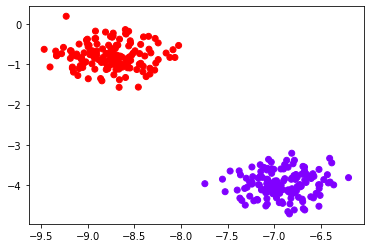

In [ ]:
from sklearn.datasets import make_blobs
Xs, ys = make_blobs(n_samples=300, centers=2, random_state=777, cluster_std=0.30)
ys = (ys - .5)*2 # converts the binary labels 0/1 -> signed labels 1/-1 
tmp = np.ones(len(Xs))  # type casting: np.int64 -> np.float64
ys = tmp * ys

plt.scatter(Xs[:, 0], Xs[:, 1], c=ys, cmap='rainbow')

Then the following code trains an SVM model using the custom code above, and attempts to visualize the decision hyperplane and maximum margin hyperplane that are found by the training algorithm.

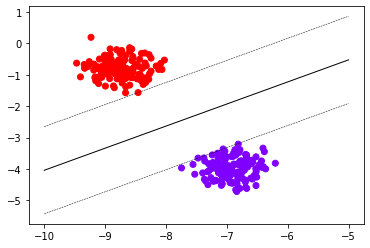

In [ ]:
svm = SVM()
svm.fit(Xs, ys)

def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]

plt.scatter(Xs[:, 0], Xs[:, 1], c=ys, cmap='rainbow')

# w.x + b = 0
a0 = -10; a1 = f(a0, svm.w, svm.b)
b0 = -5; b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k', linewidth=1)

# w.x + b = 1
a0 = -10; a1 = f(a0, svm.w, svm.b, 1)
b0 = -5; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--', linewidth=.5)

# w.x + b = -1
a0 = -10; a1 = f(a0, svm.w, svm.b, -1)
b0 = -5; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--', linewidth=.5)

#print(Xs)

Hope the above example helped you understand the provided SVM class.

Now is your turn. Let us bring back the breast cancer dataset. Notice that the original labels (`y_tr`, `y_ts`) are binary, while we need signed labels.

In [ ]:
y_tr_signed = (y_tr - .5)*2
y_ts_signed = (y_ts - .5)*2

Now let us instantiate and train SVM using the above provided class. 

In [ ]:
svm = SVM()
svm.fit(X_tr, y_tr_signed)


Use the trained model to make predictions. What are the accuracies on the training dataset and test dataset?

In [ ]:
y_tr_pred = svm.predict(X_tr)
y_ts_pred = svm.predict(X_ts)

print(get_accuracy(y_tr_signed, y_tr_pred))
print(get_accuracy(y_ts_signed, y_ts_pred))

0.6325203252032521
0.8088235294117647


On the other hand, if you use the Scikit-learn's (sklearn) built-in SVM library, it would result in much higher accuracies:

In [ ]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_tr, y_tr_signed)
y_tr_pred = svc.predict(X_tr)
y_ts_pred = svc.predict(X_ts)

print(get_accuracy(y_tr_signed, y_tr_pred))
print(get_accuracy(y_ts_signed, y_ts_pred))

0.9658536585365853
1.0


Here comes the question:

**(b) Why the provided `SVM` class did not perform well on the breast cancer dataset, while it performs perfectly on the simple data blobs in the early example? Can you make an educated guess using the components and techniques that we have discussed with SVM. You may open and examine any of  the variables loaded on the memory to investigate this.**

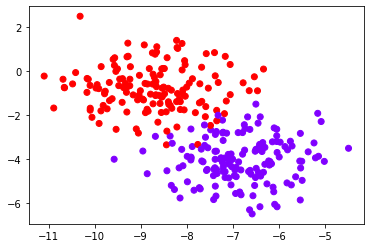

In [ ]:
bad_Xs, bad_ys = make_blobs(n_samples=300, centers=2, random_state=777, cluster_std=0.99)
bad_ys = (bad_ys - .5)*2 # converts the binary labels 0/1 -> signed labels 1/-1 
bad_tmp = np.ones(len(bad_Xs))  # type casting: np.int64 -> np.float64
bad_ys = bad_tmp * bad_ys

plt.scatter(bad_Xs[:, 0], bad_Xs[:, 1], c=bad_ys, cmap='rainbow')

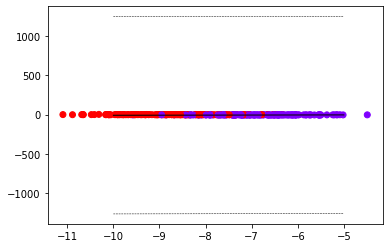

In [ ]:
bad_svm = SVM()
bad_svm.fit(bad_Xs, bad_ys)

def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]

plt.scatter(bad_Xs[:, 0], bad_Xs[:, 1], c=ys, cmap='rainbow')

# w.x + b = 0
bad_a0 = -10; bad_a1 = f(bad_a0, bad_svm.w, bad_svm.b)
bad_b0 = -5; bad_b1 = f(b0, bad_svm.w, bad_svm.b)
plt.plot([bad_a0,bad_b0], [bad_a1,bad_b1], 'k', linewidth=1)

# w.x + b = 1
bad_a0 = -10; bad_a1 = f(bad_a0, bad_svm.w, bad_svm.b, 1)
bad_b0 = -5; bad_b1 = f(bad_b0, bad_svm.w, bad_svm.b, 1)
plt.plot([bad_a0,bad_b0], [bad_a1,bad_b1], 'k--', linewidth=.5)

# w.x + b = -1
bad_a0 = -10; bad_a1 = f(bad_a0, bad_svm.w, bad_svm.b, -1)
bad_b0 = -5; bad_b1 = f(bad_b0, bad_svm.w, bad_svm.b, -1)
plt.plot([bad_a0,bad_b0], [bad_a1,bad_b1], 'k--', linewidth=.5)

In [ ]:
bad_y_pred = bad_svm.predict(bad_Xs)

print(get_accuracy(bad_ys, bad_y_pred))

0.46


**(c) If you have an answer to problem (b), can you come up with a solution? Could you describe idea in a plain text?**

Answer to this question is in the pdf file

**(d) Taking even more steps furthere, if you have an idea to address the above issue, can you extend and update the above `SVM` class, so that it performs as good as Scikit-learn's `SVC`?**

I make new_SVM class that work good as Scikit-learn's SVC.

In [ ]:
# https://github.com/corymaklin/svm/blob/master/svm.ipynb

class new_SVM:

    def fit(self, X, y , C):
        n_samples, n_features = X.shape

        # P = X^T X 
        K = np.zeros((n_samples, n_samples)) #n_samples * n_samples matrix filled with zero
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j]) 
        P = cvxopt.matrix(np.outer(y, y) * K)
        # this sequence is used for optimization in dual problem.(alpha(n) alpha(n)' y(n) y(n)' x(n)T * x(n)' )
        # P save y(n) y(n)' x(n)T * x(n)'
        # this is gram matrix

        # q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -1)

        # A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))

        # b = 0 , one instance with value 0
        b = cvxopt.matrix(0.0)
        if C is None:
          G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
          h = cvxopt.matrix(np.zeros(n_samples))
        
        else:
          tmp1 = np.diag(np.ones(n_samples) * -1)
          tmp2 = np.identity(n_samples)
          G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
          tmp1 = np.zeros(n_samples)
          tmp2 = np.ones(n_samples) * C
          h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        

        #these are the parameters for solving quadratic optimization problem.
        
        cvxopt.solvers.options['show_progress'] = False
        cvxopt.solvers.options['abstol'] = 1e-10
        #absolute accuracy
        cvxopt.solvers.options['reltol'] = 1e-10
        #relative accuracy
        cvxopt.solvers.options['maxiters'] = 500
        #maximum number of iterations
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        # this is solving quadratic program with the given data. 

        #{'x': <300x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <300x1 matrix, tc='d'>, 'z': <300x1 matrix, tc='d'>,
        # 'status': 'optimal', 'gap': 6.846660050910975e-12, 'relative gap': 1.7658983428313046e-11, 'primal objective': -0.38771541287782, 
        #'dual objective': -0.3877154128846664, 'primal infeasibility': 1.2922504951497127e-16, 
        #'dual infeasibility': 1.0724949936645799e-14, 'primal slack': 1.2329846374971779e-14, 
        #'dual slack': 5.533663752910709e-13, 'iterations': 10}

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        # this means saving only support vector by using the a value. I think a is a lagrangian multiplier. So if it is almot zeor(1e-5) it means it is not S.V
        ind = np.arange(len(a))[sv]
        #location of S.V (index of S.V)
        self.a = a[sv] # lagrange multipliers for support vector
        self.sv = X[sv] # value of S.V
        self.sv_y = y[sv] # class of the S.V

        # Intercept
        self.b = 0
        for n in range(len(self.a)): #iterate with the number of lagrange multipliers.
            self.b += self.sv_y[n] # add the class of the S.V
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
            # this is to make svm decision boundary does not always pass the origin(0,0)
            # getting a mean intercept of S.V 
            
        self.b /= len(self.a)
        #because we add them all we have to divide it by the number of S.V.

        # Weights
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]
            # because wt * x in SVM is equal to sigma(alpha(lagrange multipliers) * y(class) * x(n)t ( this is from S.V )) * x , is equation is makeing new w.
    
    
    def project(self, X):
        return np.dot(X, self.w) + self.b
    
    
    def predict(self, X):
        return np.sign(self.project(X))

In [ ]:
new_svm = new_SVM()
iter_C = np.linspace(0.0001, 0.5, num=100)

In [ ]:
max = 0.0;
best_C = 0.0;

for C in iter_C:
  new_svm.fit(X_tr, y_tr_signed , C)
  y_tr_pred = new_svm.predict(X_tr)
  y_ts_pred = new_svm.predict(X_ts)
  if get_accuracy(y_ts_signed, y_ts_pred) > max:
    max = get_accuracy(y_ts_signed, y_ts_pred)
    best_C = C

new_svm.fit(X_tr, y_tr_signed , best_C)
y_tr_pred = new_svm.predict(X_tr)
y_ts_pred = new_svm.predict(X_ts)

print(get_accuracy(y_tr_signed, y_tr_pred))
print(get_accuracy(y_ts_signed, y_ts_pred))

0.9447154471544715
1.0
